# Plágiumdetektor

A mappában található `moss` nevű Perl-szkripttel lehet beküldeni a Stanford szerverének az összehasonlítandó kódokat.

Nekem itt most három próbaszkriptem van, amik ugyanannak a Python-függvénynek a verziói:
* az eredeti
* a kicserélt változónevekkel operáló - ezt jól kezeli, hasonló marad az új kód az eredetihez
* a sorok sorrendjét megcserélő - itt már csak egymásra matchelő blokkokat talál

## Detektálás

Az összes `proba*` nevű szkript beküldése a szervernek.

In [13]:
%%bash

./moss -l python proba*.py | tail -n1 > moss_result

Meg lehet nézni egy példakimenetet:

In [14]:
print (open("moss_result").read().strip("\n"))

http://moss.stanford.edu/results/544202000


## Eredmény kiolvasása

A szerveren keletkező html olvasása, struktúrába töltése, xpath kifejezés segítségével a táblázat elemeinek kinyerése:

In [15]:
from lxml import html

tree=html.parse(open("moss_result").read().strip("\n"))
comparison=tree.xpath("//tr//td/*")

Éllista formában a fájlpárok és a közöttük levő hasonlóság eltárolása:

In [16]:
edgelist=[]
for n,x in enumerate(comparison):
    if n%2==0:
        edge=[x.text.split(" ")[0]]
    else:
        edge.append(x.text.split(" ")[0])
        edge.append({"weight":float(x.text.split(" ")[1].strip("()%"))/100})
        edgelist.append(tuple(edge))
edgelist

[('proba1.py', 'proba2.py', {'weight': 0.95}),
 ('proba2.py', 'proba3.py', {'weight': 0.57}),
 ('proba1.py', 'proba3.py', {'weight': 0.57})]

## Ábrázolás

Az egész ábrázolása egy gráfként, ahol az élek vastagsága a hasonlóságot jelenti, a csúcsok az egyes fájlok.

In [17]:
import networkx as nx
%matplotlib inline

In [18]:
G=nx.from_edgelist(edgelist)

In [19]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=15,10

(-0.20000000000000001,
 1.2000000000000002,
 -0.20000000000000001,
 1.2000000000000002)

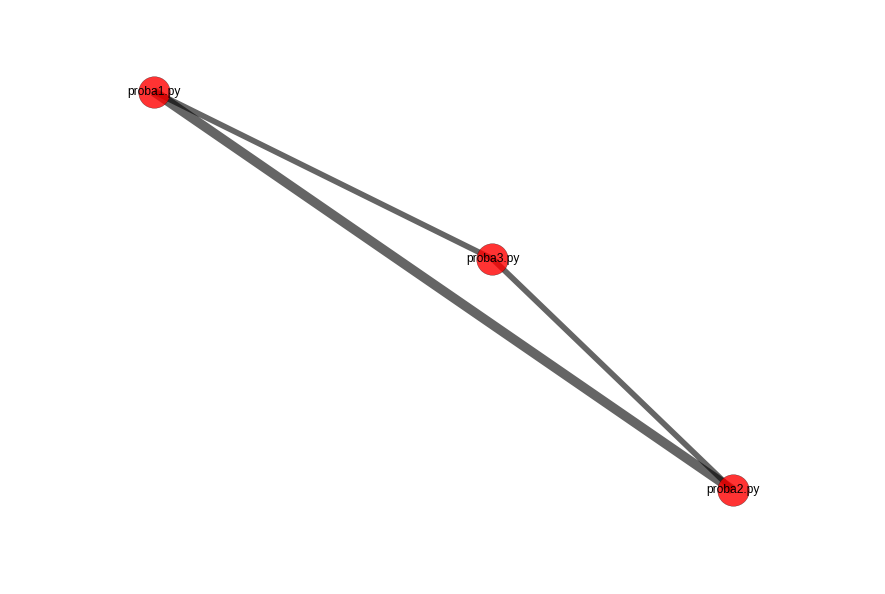

In [20]:
pos=nx.spring_layout(G)
weights = [G[u][v]['weight']*10 for u,v in G.edges()]
labels={key:key for key in G.nodes()}


nx.draw_networkx_nodes(G,pos,alpha=0.8,node_size=1000)
nx.draw_networkx_labels(G,pos)
nx.draw_networkx_edges(G,pos,width=weights,alpha=0.6)
plt.axis('off')

## Adjacenciamátrix, heatmap

Természetesen ebből könnyedén kinyerhetjük az adjacenciamátrixot:

In [21]:
A=nx.adjacency_matrix(G).todense()
A

matrix([[ 0.  ,  0.57,  0.57],
        [ 0.57,  0.  ,  0.95],
        [ 0.57,  0.95,  0.  ]])

In [22]:
import numpy as np

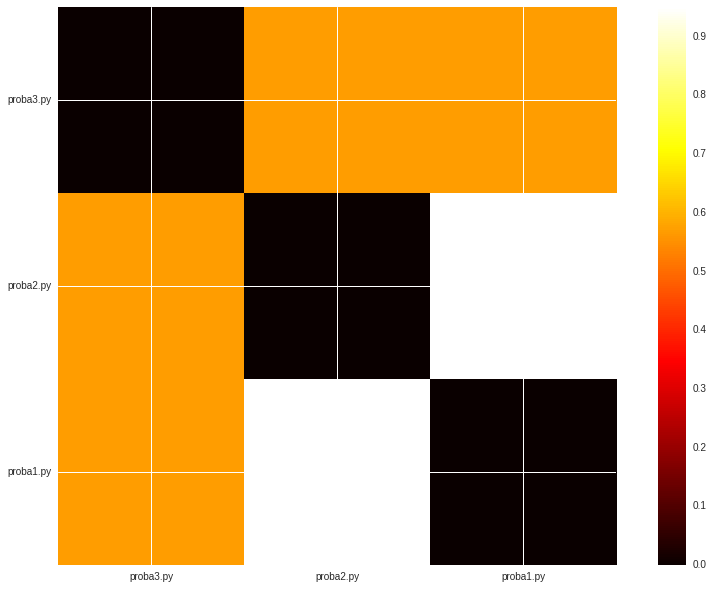

In [23]:
plt.imshow(A,interpolation='nearest',cmap="hot")
plt.xticks(range(3),G.nodes())
plt.yticks(range(3),G.nodes())
plt.colorbar()
plt.show()

### Plot és clustergram seaborn-nal

In [24]:
import seaborn as sns
import pandas as pd

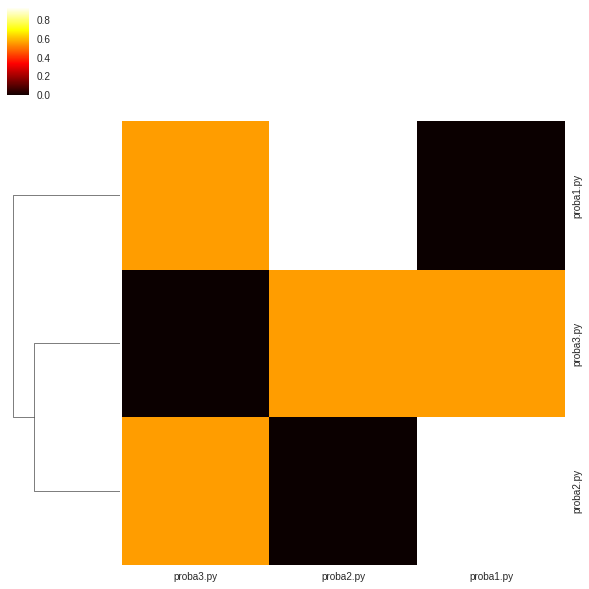

In [25]:
sns.set()
df = pd.DataFrame(A,index=G.nodes(),columns=G.nodes())
clust = sns.clustermap(df, col_cluster=False, cmap="hot")

## Tesztelés notebook-okra

A -b kapcsoló után meg lehet adni egy "base"-dokumentumot, így azokat a sorokat nem számolja bele az egyezésbe, viszont az összes sorok számába meg igen...

In [2]:
%%bash

./moss -l python -b base.ipynb proba*.ipynb | tail -n1 > moss_result

In [3]:
print (open("moss_result").read().strip("\n"))

http://moss.stanford.edu/results/174805163
